# Goal

The goal of this colab is to train a CNN on the IBM-NASA dataset for crop clasification.

# Installation

This module is dedicated for the installation of required packages for the usage of this collab.

In [1]:
!pip install segmentation-models-pytorch torch torchvision torchmetrics datasets albumentations rasterio tqdm pandas sam-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Imports

In [2]:
import os
import copy
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import time
import json


import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from segmentation_models_pytorch import UnetPlusPlus
from segmentation_models_pytorch.losses import FocalLoss, TverskyLoss
from torch.utils.tensorboard import SummaryWriter


import pandas as pd

from torchmetrics.classification import Accuracy, JaccardIndex
from torchmetrics.segmentation import DiceScore, MeanIoU

from torch.optim.lr_scheduler import PolynomialLR
from torchvision.transforms import ToTensor
from functools import lru_cache
from tqdm import tqdm

# Dataset loading
from datasets import load_dataset

# Google Drive Configuration

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Configuration

This block of code will configure all the requried global variables for the project. Some of this variables may have to be changed base on the user so make sure to check them out before executing the program.

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 14

# Trainign
EPOCHS = 50
BATCH_SIZE = 32

# Loading
NUM_WORKERS = 0

# Model params
ENCODER_NAME = "resnet34"
ENCODER_WEIGHTS = None
LEARNING_RATE = 1e-4
DECODER_ATTENTION_TYPE = "scse"
DECODER_USER_NORM = False

# Data directories
DATA_DIR = "/content/drive/MyDrive/Universidad/TFG/Implementations/nasa_ibm/"
UNET_MODEL_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/models/"
UNET_GRAPH_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/graphs/"
UNET_METRICS_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/metrics/"

SPLIT_DIR = DATA_DIR + "splited"

TRAINING_IMAGE_DIR = DATA_DIR + "training_chips_merged"
TRAINING_MASK_DIR = DATA_DIR + "training_chips_mask"

VALIDATION_IMAGE_DIR = DATA_DIR + "training_chips_merged"
VALIDATION_MASK_DIR = DATA_DIR + "training_chips_mask"

TEST_IMAGE_DIR = DATA_DIR + "test_chips_merged"
TEST_MASK_DIR = DATA_DIR + "test_chips_mask"

In [5]:
class HFDGeoDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, image_dir, mask_dir, transform=None, is_original_dataset = True ):
        self.dataset = hf_dataset
        self.to_tensor = ToTensor()
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.chip_ids = [item['text'] for item in self.dataset]

        self.image_paths = [os.path.join(image_dir, f"{chip_id}_merged.tif")
                           for chip_id in self.chip_ids]
        self.mask_paths = [os.path.join(mask_dir, f"{chip_id}.mask.tif")
                          for chip_id in self.chip_ids]


        self.use_memmap = True

    def __len__(self):
        return len(self.dataset)

    @lru_cache(maxsize=128)  # Cache recently accessed items
    def _load_image(self, image_path):
        """Load image with caching for repeated access."""
        try:
            with rasterio.open(image_path) as src:
                if self.use_memmap:
                    # Try memory-mapped reading when possible
                    image = src.read(out_shape=src.shape, masked=False)
                else:
                    image = src.read()
                return torch.from_numpy(image).type(torch.FloatTensor)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Return empty tensor or handle error appropriately
            return torch.zeros((18, 224, 224), dtype=torch.float32)

    @lru_cache(maxsize=128)
    def _load_mask(self, mask_path):
        try:
            with rasterio.open(mask_path) as chip_mask:
                mask = chip_mask.read(1)
                return torch.from_numpy(mask).type(torch.LongTensor)
        except Exception as e:
            print(f"Error loading mask {mask_path}: {e}")
            return torch.zeros((224, 224), dtype=torch.long)

    def _normalize_per_band(self, image):
        normalized = np.zeros_like(image, dtype=np.float32)

        for i in range(image.shape[0]):
            band = image[i]
            band_min = band.min()
            band_max = band.max()

            if band_max > band_min:
                normalized[i] = ((band - band_min)/(band_max - band_min))
            else:
                normalized[i] = np.zeros_like(band)

        return torch.from_numpy(normalized).float()

    def __getitem__(self, idx):
        chip_id = self.dataset[idx]['text']
        image_path = self.image_paths[idx]
        mask_path  = self.mask_paths[idx]

        image = self._load_image(image_path)
        mask  = self._load_mask(mask_path)

        image = self._normalize_per_band(image)


        return image, mask





def create_datasets(dataset, image_dirs, mask_dirs, transform = None):
    # Create train and validation datasets
    train_dataset = HFDGeoDataset(
        dataset['train'],
        image_dir=image_dirs,
        mask_dir=mask_dirs,
        transform=transform
    )

    val_dataset = HFDGeoDataset(
        dataset['validation'],
        image_dir=image_dirs,
        mask_dir=mask_dirs,
        transform=transform
    )

    return train_dataset, val_dataset

def create_data_loaders(train_dataset, val_dataset, batch_size=BATCH_SIZE, ):
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=False,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
    )

    return train_loader, val_loader


def visualize_random_rgb_sample(dataset, bands=(2, 1, 0), figsize=(10, 5)):
    """
    Picks a random sample and displays specified bands as an RGB composite,
    with per-band min/max normalization for proper visibility.

    Args:
        dataset: your HFDGeoDataset instance
        bands (tuple of int): which bands to use for R, G, B
        figsize (tuple): figure size in inches
    """
    # 1) Pick a random index
    idx = random.randint(0, len(dataset) - 1)
    image, mask = dataset[idx]       # image: Tensor[18, H, W], mask: Tensor[H, W]

    # 2) Select just the three bands and convert to a HxWx3 NumPy array
    img_bands = image[list(bands), ...]            # shape = (3, H, W)
    img_np = img_bands.permute(1, 2, 0).numpy()    # shape = (H, W, 3)

    print( image )

    # 3) Per-band min/max normalization
    for c in range(3):
        band = img_np[..., c]
        mn, mx = band.min(), band.max()
        img_np[..., c] = (band - mn) / (mx - mn + 1e-6)

    # 4) Plot side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ax1.imshow(img_np)
    ax1.set_title(f"Sample #{idx} RGB (bands {bands})")
    ax1.axis("off")

    ax2.imshow(mask.numpy(), cmap="gray")
    ax2.set_title("Mask")
    ax2.axis("off")

    plt.tight_layout()
    plt.show()

<ipython-input-5-a11c6594a13c>:57: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  normalized[i] = ((band - band_min)/(band_max - band_min))


tensor([[[0.2444, 0.2426, 0.2580,  ..., 0.4055, 0.4121, 0.4756],
         [0.2455, 0.2334, 0.2367,  ..., 0.1817, 0.1985, 0.2334],
         [0.2466, 0.2367, 0.2341,  ..., 0.1618, 0.1717, 0.1695],
         ...,
         [0.2650, 0.2554, 0.2470,  ..., 0.2488, 0.2554, 0.2602],
         [0.2983, 0.2969, 0.2723,  ..., 0.2639, 0.2664, 0.2635],
         [0.2822, 0.2811, 0.2818,  ..., 0.2657, 0.2738, 0.2807]],

        [[0.2945, 0.2936, 0.3130,  ..., 0.4431, 0.4375, 0.5184],
         [0.2972, 0.2804, 0.2876,  ..., 0.1982, 0.2179, 0.2590],
         [0.2949, 0.2834, 0.2817,  ..., 0.1801, 0.1867, 0.1880],
         ...,
         [0.3146, 0.3024, 0.2913,  ..., 0.2991, 0.3070, 0.3110],
         [0.3606, 0.3540, 0.3241,  ..., 0.3222, 0.3238, 0.3176],
         [0.3445, 0.3399, 0.3337,  ..., 0.3189, 0.3241, 0.3369]],

        [[0.3536, 0.3513, 0.3743,  ..., 0.4834, 0.4910, 0.5600],
         [0.3565, 0.3388, 0.3463,  ..., 0.2547, 0.2774, 0.3146],
         [0.3533, 0.3440, 0.3420,  ..., 0.2392, 0.2451, 0.

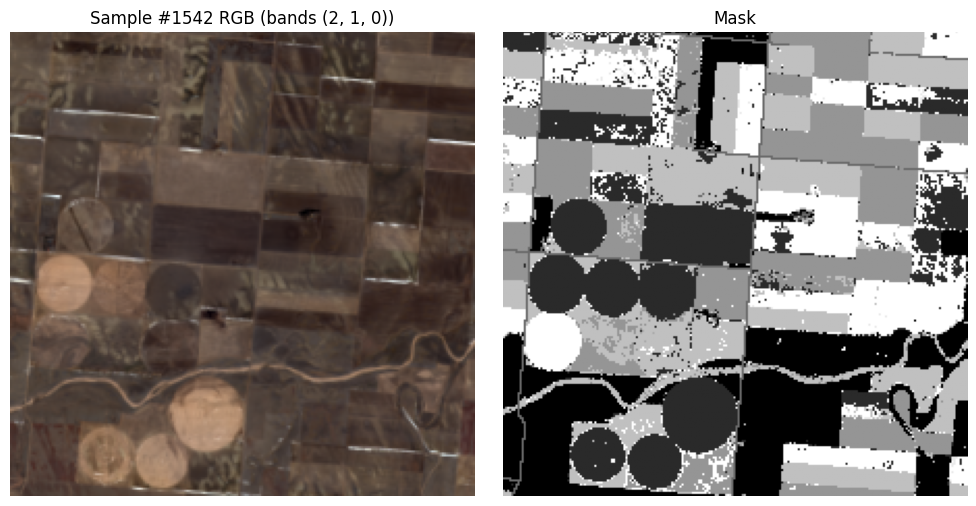

tensor([[[0.1620, 0.2096, 0.1852,  ..., 0.2101, 0.2715, 0.2820],
         [0.1192, 0.2112, 0.1982,  ..., 0.1866, 0.2262, 0.2427],
         [0.1037, 0.2087, 0.1579,  ..., 0.2842, 0.3025, 0.3218],
         ...,
         [0.0987, 0.0799, 0.1545,  ..., 0.2380, 0.2192, 0.2245],
         [0.1579, 0.1424, 0.1562,  ..., 0.1612, 0.1653, 0.1830],
         [0.1504, 0.1518, 0.1576,  ..., 0.2015, 0.2029, 0.2115]],

        [[0.1903, 0.2459, 0.2262,  ..., 0.2501, 0.3104, 0.3250],
         [0.1321, 0.2509, 0.2396,  ..., 0.2448, 0.2802, 0.2912],
         [0.1164, 0.2398, 0.1803,  ..., 0.3292, 0.3447, 0.3667],
         ...,
         [0.1248, 0.0957, 0.1848,  ..., 0.3014, 0.2700, 0.2650],
         [0.1953, 0.1782, 0.1887,  ..., 0.2063, 0.1992, 0.2092],
         [0.1740, 0.1898, 0.1861,  ..., 0.2225, 0.2204, 0.2325]],

        [[0.2787, 0.3327, 0.3208,  ..., 0.3101, 0.3672, 0.3790],
         [0.2056, 0.3404, 0.3392,  ..., 0.3101, 0.3297, 0.3334],
         [0.1856, 0.3159, 0.2587,  ..., 0.3763, 0.3821, 0.

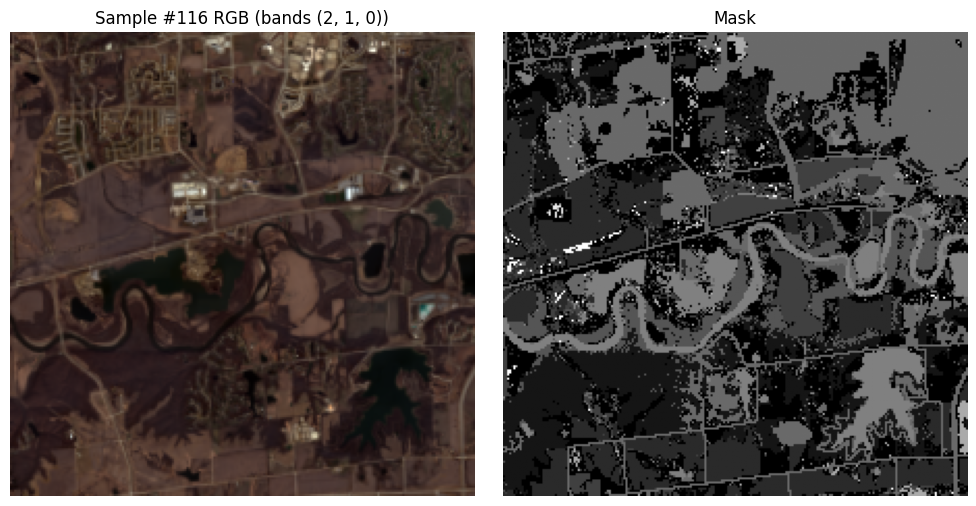

In [6]:
with open(os.path.join(SPLIT_DIR, 'dataset_splits.json')) as f:
    train_val_dataset = json.load(f)



# Create datasets
train_dataset, val_dataset = create_datasets(train_val_dataset, TRAINING_IMAGE_DIR, TRAINING_MASK_DIR)

# Create data loaders
train_loader, val_loader = create_data_loaders(train_dataset, val_dataset, batch_size=BATCH_SIZE)

visualize_random_rgb_sample(train_dataset)
visualize_random_rgb_sample(val_dataset)

In [7]:
model = UnetPlusPlus(
    encoder_name=ENCODER_NAME,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=18,
    classes=NUM_CLASSES,
    decoder_attention_type=DECODER_ATTENTION_TYPE,
    decoder_use_norm=DECODER_USER_NORM
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

focal_loss = FocalLoss(mode="multiclass", gamma=2.0)
tversky_loss =  TverskyLoss(
    mode='multiclass',
    classes=None,
    log_loss=False,
    from_logits=True,
    ignore_index=0,
    gamma=1.0
)

ce_loss = nn.CrossEntropyLoss( ignore_index = 0 );


def criterion(preds, targets):
    """
    preds: raw logits,   shape [B, C, H, W]
    targets: integer labels, shape [B, H, W]
    """
    # ensure integer dtype
    targets = targets.long()

    L_focal = focal_loss(preds, targets)

    return 1 * L_focal


scheduler = scheduler = PolynomialLR(
    optimizer,
    total_iters=EPOCHS,
    power=2.0,
    last_epoch=-1,
    verbose=True
)

In [8]:
accuracy = Accuracy(task="multiclass", average="macro",  num_classes=NUM_CLASSES).to(DEVICE)
iou = JaccardIndex(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)
dice = DiceScore( num_classes=NUM_CLASSES, average="macro",   input_format="index" ).to(DEVICE)
miou = MeanIoU(num_classes=NUM_CLASSES, include_background= False,  input_format="index"  ).to(DEVICE)

Epoch 1/50:   0%|          | 0/78 [00:00<?, ?it/s]<ipython-input-5-a11c6594a13c>:57: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  normalized[i] = ((band - band_min)/(band_max - band_min))
Epoch 1/50: 100%|██████████| 78/78 [17:56<00:00, 13.80s/it]


[Epoch  0] Loss:  1.8397, Acc:   0.0708, IoU:   0.0098, Dice:  0.0114, mIoU:  0.0070


Epoch 1/50 [Val]: 100%|██████████| 20/20 [02:28<00:00,  7.40s/it]


[Epoch  0] Loss: 1.1085, Acc: 0.0739, IoU: 0.0127, Dice: 0.0187, mIoU: 0.0116


Epoch 2/50: 100%|██████████| 78/78 [10:21<00:00,  7.96s/it]


[Epoch  1] Loss:  0.9561, Acc:   0.0907, IoU:   0.0425, Dice:  0.0474, mIoU:  0.0308


Epoch 2/50 [Val]: 100%|██████████| 20/20 [02:12<00:00,  6.60s/it]


[Epoch  1] Loss: 0.8902, Acc: 0.1205, IoU: 0.0634, Dice: 0.0668, mIoU: 0.0444


Epoch 3/50: 100%|██████████| 78/78 [09:38<00:00,  7.41s/it]


[Epoch  2] Loss:  0.8682, Acc:   0.1406, IoU:   0.0788, Dice:  0.0732, mIoU:  0.0499


Epoch 3/50 [Val]: 100%|██████████| 20/20 [02:08<00:00,  6.45s/it]


[Epoch  2] Loss: 0.8464, Acc: 0.1595, IoU: 0.0930, Dice: 0.0882, mIoU: 0.0609


Epoch 4/50: 100%|██████████| 78/78 [10:22<00:00,  7.98s/it]


[Epoch  3] Loss:  0.8237, Acc:   0.1739, IoU:   0.1052, Dice:  0.0939, mIoU:  0.0657


Epoch 4/50 [Val]: 100%|██████████| 20/20 [02:06<00:00,  6.35s/it]


[Epoch  3] Loss: 0.8065, Acc: 0.1918, IoU: 0.1157, Dice: 0.1045, mIoU: 0.0748


Epoch 5/50: 100%|██████████| 78/78 [09:31<00:00,  7.33s/it]


[Epoch  4] Loss:  0.7906, Acc:   0.2025, IoU:   0.1245, Dice:  0.1090, mIoU:  0.0782


Epoch 5/50 [Val]: 100%|██████████| 20/20 [02:06<00:00,  6.31s/it]


[Epoch  4] Loss: 0.7824, Acc: 0.2091, IoU: 0.1276, Dice: 0.1144, mIoU: 0.0827


Epoch 6/50: 100%|██████████| 78/78 [10:09<00:00,  7.81s/it]


[Epoch  5] Loss:  0.7656, Acc:   0.2206, IoU:   0.1361, Dice:  0.1187, mIoU:  0.0861


Epoch 6/50 [Val]: 100%|██████████| 20/20 [02:05<00:00,  6.28s/it]


[Epoch  5] Loss: 0.7584, Acc: 0.2288, IoU: 0.1424, Dice: 0.1259, mIoU: 0.0912


Epoch 7/50: 100%|██████████| 78/78 [09:41<00:00,  7.45s/it]


[Epoch  6] Loss:  0.7444, Acc:   0.2408, IoU:   0.1519, Dice:  0.1301, mIoU:  0.0951


Epoch 7/50 [Val]: 100%|██████████| 20/20 [02:04<00:00,  6.21s/it]


[Epoch  6] Loss: 0.7529, Acc: 0.2424, IoU: 0.1545, Dice: 0.1335, mIoU: 0.0974


Epoch 8/50: 100%|██████████| 78/78 [09:30<00:00,  7.31s/it]


[Epoch  7] Loss:  0.7330, Acc:   0.2563, IoU:   0.1633, Dice:  0.1378, mIoU:  0.1018


Epoch 8/50 [Val]: 100%|██████████| 20/20 [02:02<00:00,  6.12s/it]


[Epoch  7] Loss: 0.7371, Acc: 0.2677, IoU: 0.1717, Dice: 0.1470, mIoU: 0.1078


Epoch 9/50: 100%|██████████| 78/78 [09:19<00:00,  7.17s/it]


[Epoch  8] Loss:  0.7247, Acc:   0.2649, IoU:   0.1697, Dice:  0.1428, mIoU:  0.1063


Epoch 9/50 [Val]: 100%|██████████| 20/20 [02:07<00:00,  6.38s/it]


[Epoch  8] Loss: 0.7311, Acc: 0.2589, IoU: 0.1668, Dice: 0.1449, mIoU: 0.1073


Epoch 10/50: 100%|██████████| 78/78 [09:40<00:00,  7.45s/it]


[Epoch  9] Loss:  0.7064, Acc:   0.2827, IoU:   0.1840, Dice:  0.1518, mIoU:  0.1133


Epoch 10/50 [Val]: 100%|██████████| 20/20 [02:00<00:00,  6.01s/it]


[Epoch  9] Loss: 0.7187, Acc: 0.2839, IoU: 0.1844, Dice: 0.1551, mIoU: 0.1154


Epoch 11/50: 100%|██████████| 78/78 [09:10<00:00,  7.06s/it]


[Epoch 10] Loss:  0.6963, Acc:   0.2963, IoU:   0.1944, Dice:  0.1577, mIoU:  0.1180


Epoch 11/50 [Val]: 100%|██████████| 20/20 [02:00<00:00,  6.05s/it]


[Epoch 10] Loss: 0.7190, Acc: 0.2763, IoU: 0.1790, Dice: 0.1522, mIoU: 0.1135


Epoch 12/50: 100%|██████████| 78/78 [09:31<00:00,  7.32s/it]


[Epoch 11] Loss:  0.6896, Acc:   0.3053, IoU:   0.2011, Dice:  0.1617, mIoU:  0.1212


Epoch 12/50 [Val]: 100%|██████████| 20/20 [02:00<00:00,  6.02s/it]


[Epoch 11] Loss: 0.7016, Acc: 0.3003, IoU: 0.1968, Dice: 0.1624, mIoU: 0.1213


Epoch 13/50: 100%|██████████| 78/78 [09:31<00:00,  7.33s/it]


[Epoch 12] Loss:  0.6808, Acc:   0.3155, IoU:   0.2084, Dice:  0.1669, mIoU:  0.1255


Epoch 13/50 [Val]: 100%|██████████| 20/20 [02:07<00:00,  6.36s/it]


[Epoch 12] Loss: 0.7401, Acc: 0.2769, IoU: 0.1854, Dice: 0.1499, mIoU: 0.1120


Epoch 14/50: 100%|██████████| 78/78 [09:51<00:00,  7.59s/it]


[Epoch 13] Loss:  0.6710, Acc:   0.3255, IoU:   0.2159, Dice:  0.1719, mIoU:  0.1300


Epoch 14/50 [Val]: 100%|██████████| 20/20 [02:06<00:00,  6.33s/it]


[Epoch 13] Loss: 0.7021, Acc: 0.3012, IoU: 0.2013, Dice: 0.1631, mIoU: 0.1242


Epoch 15/50: 100%|██████████| 78/78 [09:57<00:00,  7.66s/it]


[Epoch 14] Loss:  0.6612, Acc:   0.3346, IoU:   0.2229, Dice:  0.1768, mIoU:  0.1346


Epoch 15/50 [Val]: 100%|██████████| 20/20 [02:13<00:00,  6.65s/it]


[Epoch 14] Loss: 0.6805, Acc: 0.3230, IoU: 0.2153, Dice: 0.1742, mIoU: 0.1327


Epoch 16/50: 100%|██████████| 78/78 [10:01<00:00,  7.71s/it]


[Epoch 15] Loss:  0.6500, Acc:   0.3455, IoU:   0.2316, Dice:  0.1834, mIoU:  0.1405


Epoch 16/50 [Val]: 100%|██████████| 20/20 [02:04<00:00,  6.20s/it]


[Epoch 15] Loss: 0.6866, Acc: 0.3133, IoU: 0.2112, Dice: 0.1739, mIoU: 0.1327


Epoch 17/50: 100%|██████████| 78/78 [09:42<00:00,  7.47s/it]


[Epoch 16] Loss:  0.6406, Acc:   0.3547, IoU:   0.2390, Dice:  0.1886, mIoU:  0.1451


Epoch 17/50 [Val]: 100%|██████████| 20/20 [02:09<00:00,  6.49s/it]


[Epoch 16] Loss: 0.6869, Acc: 0.3270, IoU: 0.2166, Dice: 0.1775, mIoU: 0.1350


Epoch 18/50: 100%|██████████| 78/78 [10:03<00:00,  7.73s/it]


[Epoch 17] Loss:  0.6348, Acc:   0.3613, IoU:   0.2440, Dice:  0.1919, mIoU:  0.1486


Epoch 18/50 [Val]: 100%|██████████| 20/20 [02:07<00:00,  6.37s/it]


[Epoch 17] Loss: 0.6674, Acc: 0.3434, IoU: 0.2285, Dice: 0.1869, mIoU: 0.1435


Epoch 19/50: 100%|██████████| 78/78 [09:28<00:00,  7.28s/it]


[Epoch 18] Loss:  0.6265, Acc:   0.3687, IoU:   0.2501, Dice:  0.1962, mIoU:  0.1527


Epoch 19/50 [Val]: 100%|██████████| 20/20 [02:14<00:00,  6.74s/it]


[Epoch 18] Loss: 0.6755, Acc: 0.3355, IoU: 0.2238, Dice: 0.1840, mIoU: 0.1416


Epoch 20/50: 100%|██████████| 78/78 [10:28<00:00,  8.05s/it]


[Epoch 19] Loss:  0.6179, Acc:   0.3773, IoU:   0.2572, Dice:  0.2008, mIoU:  0.1571


Epoch 20/50 [Val]: 100%|██████████| 20/20 [02:20<00:00,  7.03s/it]


[Epoch 19] Loss: 0.6787, Acc: 0.3361, IoU: 0.2238, Dice: 0.1826, mIoU: 0.1409


Epoch 21/50: 100%|██████████| 78/78 [10:25<00:00,  8.02s/it]


[Epoch 20] Loss:  0.6110, Acc:   0.3830, IoU:   0.2622, Dice:  0.2042, mIoU:  0.1603


Epoch 21/50 [Val]: 100%|██████████| 20/20 [02:10<00:00,  6.54s/it]


[Epoch 20] Loss: 0.6640, Acc: 0.3433, IoU: 0.2312, Dice: 0.1892, mIoU: 0.1469


Epoch 22/50: 100%|██████████| 78/78 [09:42<00:00,  7.46s/it]


[Epoch 21] Loss:  0.6038, Acc:   0.3898, IoU:   0.2678, Dice:  0.2079, mIoU:  0.1643


Epoch 22/50 [Val]: 100%|██████████| 20/20 [02:05<00:00,  6.30s/it]


[Epoch 21] Loss: 0.6863, Acc: 0.3136, IoU: 0.2156, Dice: 0.1833, mIoU: 0.1428


Epoch 23/50: 100%|██████████| 78/78 [09:41<00:00,  7.46s/it]


[Epoch 22] Loss:  0.5995, Acc:   0.3940, IoU:   0.2719, Dice:  0.2107, mIoU:  0.1668


Epoch 23/50 [Val]: 100%|██████████| 20/20 [02:00<00:00,  6.01s/it]


[Epoch 22] Loss: 0.6698, Acc: 0.3309, IoU: 0.2260, Dice: 0.1892, mIoU: 0.1475


Epoch 24/50: 100%|██████████| 78/78 [09:13<00:00,  7.09s/it]


[Epoch 23] Loss:  0.5936, Acc:   0.4019, IoU:   0.2786, Dice:  0.2147, mIoU:  0.1703


Epoch 24/50 [Val]: 100%|██████████| 20/20 [02:11<00:00,  6.58s/it]


[Epoch 23] Loss: 0.6589, Acc: 0.3574, IoU: 0.2439, Dice: 0.1920, mIoU: 0.1525


Epoch 25/50: 100%|██████████| 78/78 [09:52<00:00,  7.60s/it]


[Epoch 24] Loss:  0.5881, Acc:   0.4059, IoU:   0.2822, Dice:  0.2171, mIoU:  0.1732


Epoch 25/50 [Val]: 100%|██████████| 20/20 [02:16<00:00,  6.81s/it]


[Epoch 24] Loss: 0.6726, Acc: 0.3464, IoU: 0.2332, Dice: 0.1898, mIoU: 0.1500


Epoch 26/50: 100%|██████████| 78/78 [09:28<00:00,  7.28s/it]


[Epoch 25] Loss:  0.5857, Acc:   0.4072, IoU:   0.2838, Dice:  0.2190, mIoU:  0.1748


Epoch 26/50 [Val]: 100%|██████████| 20/20 [02:06<00:00,  6.34s/it]


[Epoch 25] Loss: 0.6550, Acc: 0.3679, IoU: 0.2532, Dice: 0.1963, mIoU: 0.1554


Epoch 27/50: 100%|██████████| 78/78 [09:16<00:00,  7.13s/it]


[Epoch 26] Loss:  0.5792, Acc:   0.4157, IoU:   0.2908, Dice:  0.2221, mIoU:  0.1783


Epoch 27/50 [Val]: 100%|██████████| 20/20 [02:05<00:00,  6.27s/it]


[Epoch 26] Loss: 0.6525, Acc: 0.3774, IoU: 0.2581, Dice: 0.1991, mIoU: 0.1567


Epoch 28/50: 100%|██████████| 78/78 [10:09<00:00,  7.81s/it]


[Epoch 27] Loss:  0.5739, Acc:   0.4528, IoU:   0.3181, Dice:  0.2245, mIoU:  0.1805


Epoch 28/50 [Val]: 100%|██████████| 20/20 [02:04<00:00,  6.22s/it]


[Epoch 27] Loss: 0.6762, Acc: 0.3709, IoU: 0.2488, Dice: 0.1951, mIoU: 0.1514


Epoch 29/50: 100%|██████████| 78/78 [09:59<00:00,  7.68s/it]


[Epoch 28] Loss:  0.5722, Acc:   0.4555, IoU:   0.3206, Dice:  0.2258, mIoU:  0.1819


Epoch 29/50 [Val]: 100%|██████████| 20/20 [02:10<00:00,  6.52s/it]


[Epoch 28] Loss: 0.6802, Acc: 0.3641, IoU: 0.2423, Dice: 0.1938, mIoU: 0.1496


Epoch 30/50: 100%|██████████| 78/78 [10:05<00:00,  7.76s/it]


[Epoch 29] Loss:  0.5702, Acc:   0.4565, IoU:   0.3225, Dice:  0.2273, mIoU:  0.1840


Epoch 30/50 [Val]: 100%|██████████| 20/20 [02:07<00:00,  6.37s/it]


[Epoch 29] Loss: 0.6608, Acc: 0.3879, IoU: 0.2550, Dice: 0.1977, mIoU: 0.1518


Epoch 31/50: 100%|██████████| 78/78 [10:21<00:00,  7.97s/it]


[Epoch 30] Loss:  0.5619, Acc:   0.4674, IoU:   0.3312, Dice:  0.2319, mIoU:  0.1884


Epoch 31/50 [Val]: 100%|██████████| 20/20 [02:17<00:00,  6.86s/it]


[Epoch 30] Loss: 0.6402, Acc: 0.4028, IoU: 0.2711, Dice: 0.2103, mIoU: 0.1661


Epoch 32/50: 100%|██████████| 78/78 [09:54<00:00,  7.62s/it]


[Epoch 31] Loss:  0.5502, Acc:   0.4799, IoU:   0.3432, Dice:  0.2384, mIoU:  0.1947


Epoch 32/50 [Val]: 100%|██████████| 20/20 [02:30<00:00,  7.54s/it]


[Epoch 31] Loss: 0.6417, Acc: 0.3998, IoU: 0.2746, Dice: 0.2124, mIoU: 0.1681


Epoch 33/50: 100%|██████████| 78/78 [09:15<00:00,  7.12s/it]


[Epoch 32] Loss:  0.5415, Acc:   0.4894, IoU:   0.3520, Dice:  0.2436, mIoU:  0.1994


Epoch 33/50 [Val]: 100%|██████████| 20/20 [02:02<00:00,  6.14s/it]


[Epoch 32] Loss: 0.6545, Acc: 0.3910, IoU: 0.2696, Dice: 0.2099, mIoU: 0.1660


Epoch 34/50: 100%|██████████| 78/78 [09:44<00:00,  7.49s/it]


[Epoch 33] Loss:  0.5382, Acc:   0.4936, IoU:   0.3563, Dice:  0.2458, mIoU:  0.2017


Epoch 34/50 [Val]: 100%|██████████| 20/20 [02:02<00:00,  6.12s/it]


[Epoch 33] Loss: 0.6755, Acc: 0.3849, IoU: 0.2643, Dice: 0.2033, mIoU: 0.1612


Epoch 35/50: 100%|██████████| 78/78 [09:26<00:00,  7.27s/it]


[Epoch 34] Loss:  0.5355, Acc:   0.4981, IoU:   0.3604, Dice:  0.2482, mIoU:  0.2042


Epoch 35/50 [Val]: 100%|██████████| 20/20 [02:03<00:00,  6.19s/it]


[Epoch 34] Loss: 0.6335, Acc: 0.4204, IoU: 0.2892, Dice: 0.2189, mIoU: 0.1756


Epoch 36/50: 100%|██████████| 78/78 [09:20<00:00,  7.18s/it]


[Epoch 35] Loss:  0.5292, Acc:   0.5067, IoU:   0.3685, Dice:  0.2513, mIoU:  0.2074


Epoch 36/50 [Val]: 100%|██████████| 20/20 [02:00<00:00,  6.02s/it]


[Epoch 35] Loss: 0.6651, Acc: 0.3969, IoU: 0.2710, Dice: 0.2120, mIoU: 0.1698


Epoch 37/50: 100%|██████████| 78/78 [09:49<00:00,  7.55s/it]


[Epoch 36] Loss:  0.5245, Acc:   0.5136, IoU:   0.3755, Dice:  0.2551, mIoU:  0.2114


Epoch 37/50 [Val]: 100%|██████████| 20/20 [02:03<00:00,  6.17s/it]


[Epoch 36] Loss: 0.6451, Acc: 0.4227, IoU: 0.2874, Dice: 0.2175, mIoU: 0.1735


Epoch 38/50: 100%|██████████| 78/78 [09:09<00:00,  7.04s/it]


[Epoch 37] Loss:  0.5235, Acc:   0.4803, IoU:   0.3514, Dice:  0.2565, mIoU:  0.2126


Epoch 38/50 [Val]: 100%|██████████| 20/20 [02:01<00:00,  6.08s/it]


[Epoch 37] Loss: 0.6706, Acc: 0.4081, IoU: 0.2754, Dice: 0.2078, mIoU: 0.1632


Epoch 39/50: 100%|██████████| 78/78 [09:17<00:00,  7.15s/it]


[Epoch 38] Loss:  0.5239, Acc:   0.4819, IoU:   0.3528, Dice:  0.2569, mIoU:  0.2133


Epoch 39/50 [Val]: 100%|██████████| 20/20 [02:05<00:00,  6.27s/it]


[Epoch 38] Loss: 0.6810, Acc: 0.3813, IoU: 0.2625, Dice: 0.2024, mIoU: 0.1624


Epoch 40/50: 100%|██████████| 78/78 [09:47<00:00,  7.53s/it]


[Epoch 39] Loss:  0.5198, Acc:   0.4873, IoU:   0.3577, Dice:  0.2594, mIoU:  0.2161


Epoch 40/50 [Val]: 100%|██████████| 20/20 [02:07<00:00,  6.36s/it]


[Epoch 39] Loss: 0.6513, Acc: 0.4099, IoU: 0.2828, Dice: 0.2120, mIoU: 0.1685


Epoch 41/50: 100%|██████████| 78/78 [09:15<00:00,  7.13s/it]


[Epoch 40] Loss:  0.5163, Acc:   0.4920, IoU:   0.3620, Dice:  0.2612, mIoU:  0.2186


Epoch 41/50 [Val]: 100%|██████████| 20/20 [02:05<00:00,  6.26s/it]


[Epoch 40] Loss: 0.6485, Acc: 0.4125, IoU: 0.2838, Dice: 0.2197, mIoU: 0.1764


Epoch 42/50: 100%|██████████| 78/78 [09:55<00:00,  7.63s/it]


[Epoch 41] Loss:  0.5081, Acc:   0.5012, IoU:   0.3704, Dice:  0.2663, mIoU:  0.2235


Epoch 42/50 [Val]: 100%|██████████| 20/20 [02:03<00:00,  6.15s/it]


[Epoch 41] Loss: 0.6560, Acc: 0.4020, IoU: 0.2765, Dice: 0.2198, mIoU: 0.1764


Epoch 43/50: 100%|██████████| 78/78 [09:05<00:00,  7.00s/it]


[Epoch 42] Loss:  0.5029, Acc:   0.5088, IoU:   0.3769, Dice:  0.2691, mIoU:  0.2268


Epoch 43/50 [Val]: 100%|██████████| 20/20 [01:59<00:00,  5.95s/it]


[Epoch 42] Loss: 0.6448, Acc: 0.4142, IoU: 0.2877, Dice: 0.2178, mIoU: 0.1702


Epoch 44/50: 100%|██████████| 78/78 [09:50<00:00,  7.57s/it]


[Epoch 43] Loss:  0.5025, Acc:   0.5097, IoU:   0.3779, Dice:  0.2697, mIoU:  0.2275


Epoch 44/50 [Val]: 100%|██████████| 20/20 [02:05<00:00,  6.28s/it]


[Epoch 43] Loss: 0.6432, Acc: 0.3883, IoU: 0.2651, Dice: 0.2228, mIoU: 0.1739


Epoch 45/50: 100%|██████████| 78/78 [09:07<00:00,  7.03s/it]


[Epoch 44] Loss:  0.5025, Acc:   0.5120, IoU:   0.3794, Dice:  0.2707, mIoU:  0.2284


Epoch 45/50 [Val]: 100%|██████████| 20/20 [02:04<00:00,  6.25s/it]


[Epoch 44] Loss: 0.6432, Acc: 0.3775, IoU: 0.2591, Dice: 0.2233, mIoU: 0.1766


Epoch 46/50: 100%|██████████| 78/78 [09:36<00:00,  7.40s/it]


[Epoch 45] Loss:  0.4980, Acc:   0.5186, IoU:   0.3850, Dice:  0.2739, mIoU:  0.2319


Epoch 46/50 [Val]: 100%|██████████| 20/20 [02:06<00:00,  6.35s/it]


[Epoch 45] Loss: 0.7252, Acc: 0.3294, IoU: 0.2213, Dice: 0.2036, mIoU: 0.1663


Epoch 47/50: 100%|██████████| 78/78 [09:40<00:00,  7.45s/it]


[Epoch 46] Loss:  0.4919, Acc:   0.5240, IoU:   0.3897, Dice:  0.2772, mIoU:  0.2356


Epoch 47/50 [Val]: 100%|██████████| 20/20 [02:12<00:00,  6.61s/it]


[Epoch 46] Loss: 0.7287, Acc: 0.3587, IoU: 0.2420, Dice: 0.2008, mIoU: 0.1624


Epoch 48/50: 100%|██████████| 78/78 [10:35<00:00,  8.15s/it]


[Epoch 47] Loss:  0.4877, Acc:   0.5280, IoU:   0.3942, Dice:  0.2795, mIoU:  0.2384


Epoch 48/50 [Val]: 100%|██████████| 20/20 [02:33<00:00,  7.66s/it]


[Epoch 47] Loss: 0.6776, Acc: 0.3894, IoU: 0.2691, Dice: 0.2120, mIoU: 0.1699


Epoch 49/50: 100%|██████████| 78/78 [09:41<00:00,  7.45s/it]


[Epoch 48] Loss:  0.4858, Acc:   0.5331, IoU:   0.3982, Dice:  0.2813, mIoU:  0.2405


Epoch 49/50 [Val]: 100%|██████████| 20/20 [02:09<00:00,  6.48s/it]


[Epoch 48] Loss: 0.6865, Acc: 0.4030, IoU: 0.2654, Dice: 0.2058, mIoU: 0.1640


Epoch 50/50: 100%|██████████| 78/78 [10:08<00:00,  7.81s/it]


[Epoch 49] Loss:  0.4861, Acc:   0.5316, IoU:   0.3968, Dice:  0.2810, mIoU:  0.2409


Epoch 50/50 [Val]: 100%|██████████| 20/20 [02:13<00:00,  6.65s/it]


[Epoch 49] Loss: 0.6291, Acc: 0.3985, IoU: 0.2721, Dice: 0.2241, mIoU: 0.1797


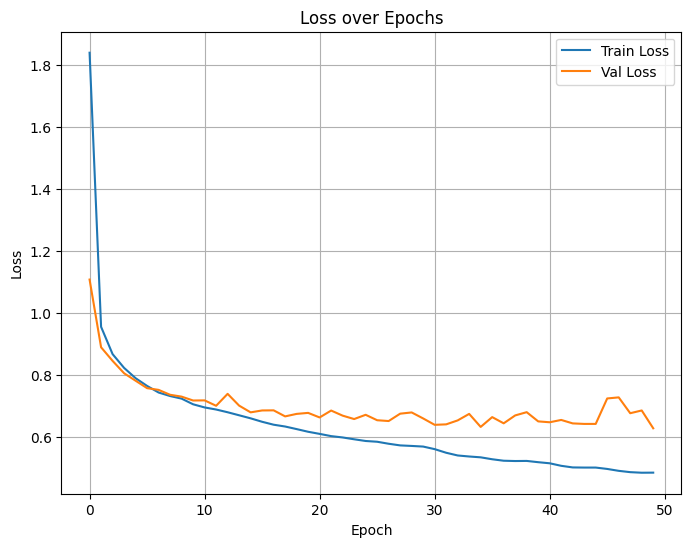

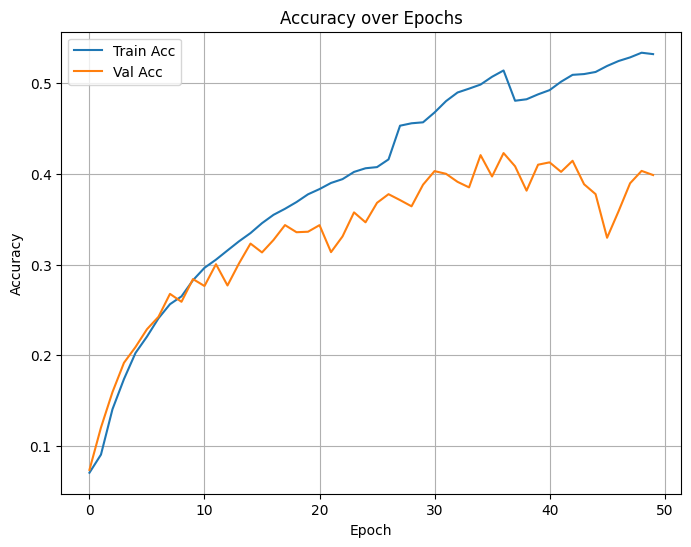

In [9]:


writer = SummaryWriter(log_dir="runs/experiment1")

labels = {
      0: "No Data",
      1: "Natural Vegetation",
      2: "Forest",
      3: "Corn",
      4: "Soybeans",
      5: "Wetlands",
      6: "Developed Barren",
      7: "Open Water",
      8: "Winter Wheat",
      9: "Alfalfa",
      10: "Fallow Idle Cropland",
      11: "Cotton",
      12: "Sorghum",
      13: "Other"
  }

train_losses, train_accs, train_ious, train_mious, train_dices = [], [], [], [], []
val_losses,   val_accs,   val_ious,   val_mious,  val_dices = [], [], [], [], []
best_val_acc = 0.0
best_epoch     = 0
best_model_wts = None

for epoch in range(EPOCHS):
    model.train()
    train_loss_sum = train_acc_sum = train_iou_sum = train_dice_sum = train_miou_sum = 0.0
    accuracy.reset(); iou.reset(); dice.reset(); miou.reset()

    ### ——— TRAIN ———
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, masks = images.to(DEVICE), masks.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)

        accuracy.update(preds, masks)
        iou      .update(preds, masks)
        dice     .update(preds, masks)
        miou     .update(preds, masks)

        train_loss_sum  += loss.item()

    # Average metrics
    train_losses.append(train_loss_sum / len(train_loader))
    train_accs  .append(accuracy.compute().item())
    train_ious  .append(iou.compute().item())
    train_dices .append(dice.compute().item())
    train_mious .append(miou.compute().item())

    writer.add_scalar('Loss/train', train_losses[-1], epoch)
    writer.add_scalar('Accuracy/train', train_accs[-1], epoch)
    writer.add_scalar('IoU/train', train_ious[-1], epoch)
    writer.add_scalar('Dice/train', train_dices[-1], epoch)
    writer.add_scalar('mIoU/train', train_mious[-1], epoch)


    tqdm.write(
        f"[Epoch {epoch:>2d}] "
        f"Loss:  {train_losses[-1]:.4f}, "
        f"Acc:   {train_accs[-1]:.4f}, "
        f"IoU:   {train_ious[-1]:.4f}, "
        f"Dice:  {train_dices[-1]:.4f}, "
        f"mIoU:  {train_mious[-1]:.4f}"
    )

    ### ——— VALIDATION ———
    model.eval()
    val_loss_sum = val_acc_sum = val_iou_sum = val_dice_sum = val_miou_sum = 0.0
    accuracy.reset(); iou.reset(); dice.reset(); miou.reset()

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, masks)

            preds = torch.argmax(outputs, dim=1)

            accuracy.update(preds, masks)
            iou      .update(preds, masks)
            dice     .update(preds, masks)
            miou     .update(preds, masks)

            val_loss_sum  += loss.item()

    # Average metrics
    val_acc = accuracy.compute().item()
    val_losses.append(val_loss_sum / len(val_loader))
    val_accs  .append(val_acc)
    val_ious  .append(iou.compute().item())
    val_dices .append(dice.compute().item())
    val_mious .append(miou.compute().item())

    # Log to TensorBoard
    writer.add_scalar('Loss/val', val_losses[-1], epoch)
    writer.add_scalar('Accuracy/val', val_accs[-1], epoch)
    writer.add_scalar('IoU/val', val_ious[-1], epoch)
    writer.add_scalar('Dice/val', val_dices[-1], epoch)
    writer.add_scalar('mIoU/val', val_mious[-1], epoch)

    tqdm.write(
        f"[Epoch {epoch:>2d}] "
        f"Loss: {val_losses[-1]:.4f}, "
        f"Acc: {val_accs[-1]:.4f}, "
        f"IoU: {val_ious[-1]:.4f}, "
        f"Dice: {val_dices[-1]:.4f}, "
        f"mIoU: {val_mious[-1]:.4f}"
    )

    # Scheduler step on validation loss
    scheduler.step(val_losses[-1])

    if val_acc > best_val_acc:
        best_val_acc   = val_acc
        best_epoch     = epoch + 1
        best_model_wts = copy.deepcopy(model.state_dict())


model.load_state_dict(best_model_wts)


# After training, plot metrics separately
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(train_accs,  label='Train Acc')
plt.plot(val_accs,    label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Close TensorBoard writer
writer.close()


Saved Loss plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/graphs/unet++_resnet34_None_32bs_50ep_lr1e-04_loss_20250516-210044_normalized_polynomial_trevesky.png


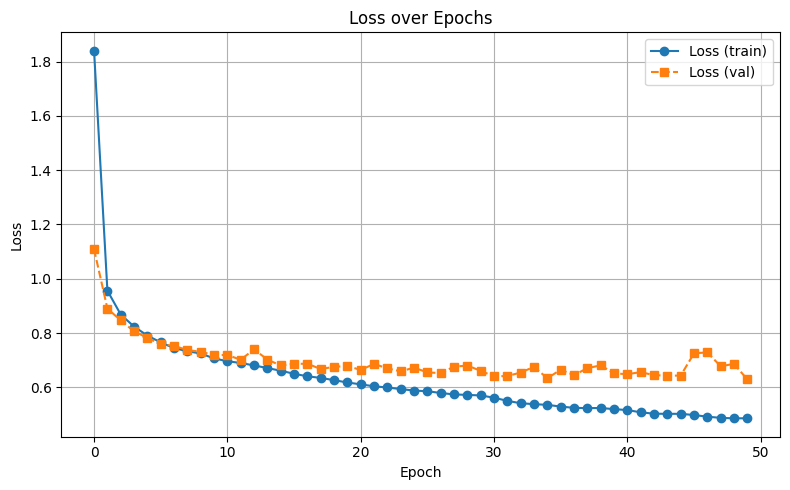

Saved Accuracy plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/graphs/unet++_resnet34_None_32bs_50ep_lr1e-04_accuracy_20250516-210044_normalized_polynomial_trevesky.png


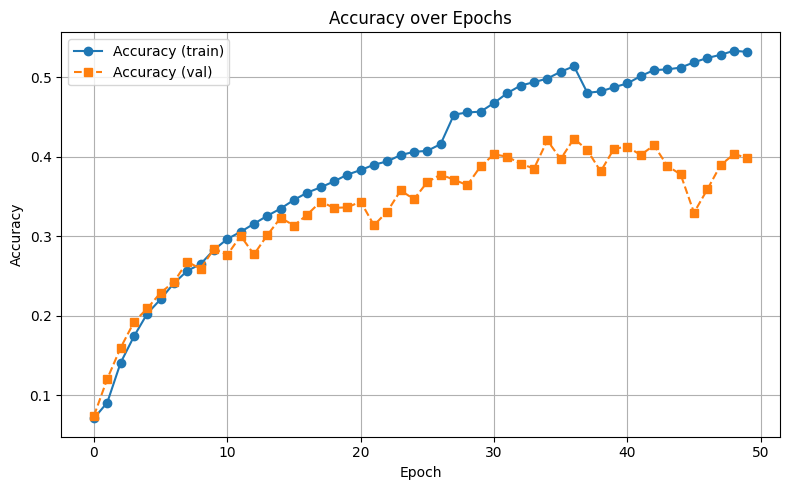

Saved Iou plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/graphs/unet++_resnet34_None_32bs_50ep_lr1e-04_iou_20250516-210044_normalized_polynomial_trevesky.png


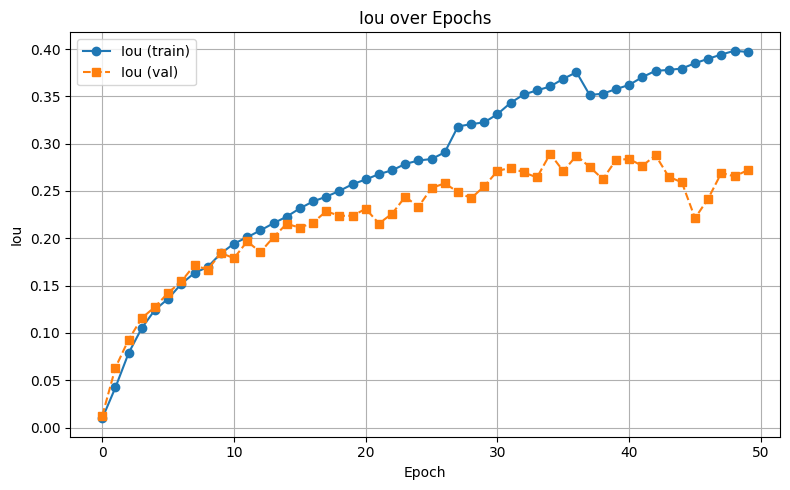

Saved Dice plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/graphs/unet++_resnet34_None_32bs_50ep_lr1e-04_dice_20250516-210044_normalized_polynomial_trevesky.png


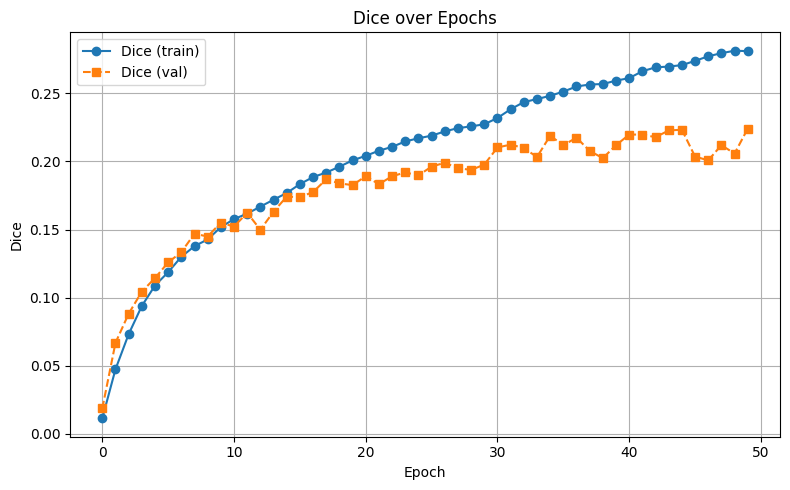

Saved Miou plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/graphs/unet++_resnet34_None_32bs_50ep_lr1e-04_miou_20250516-210044_normalized_polynomial_trevesky.png


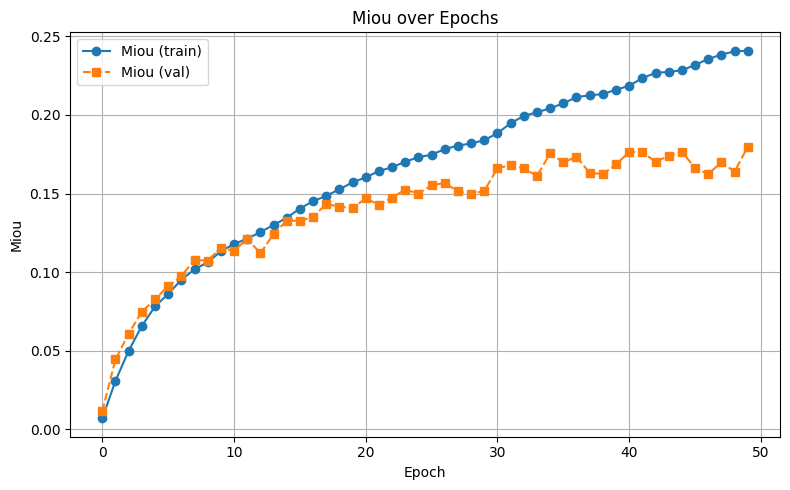

In [10]:
timestamp = time.strftime("%Y%m%d-%H%M%S")

all_metrics = {
    'loss':  (train_losses, val_losses),
    'accuracy': (train_accs, val_accs),
    'iou':    (train_ious, val_ious),
    'dice':   (train_dices, val_dices),
    'miou':   (train_mious, val_mious),
}

for metric_name, (train_vals, val_vals) in all_metrics.items():
    plt.figure(figsize=(8, 5))
    plt.plot(train_vals, marker='o', linestyle='-', label=f'{metric_name.title()} (train)')
    plt.plot(val_vals,   marker='s', linestyle='--', label=f'{metric_name.title()} (val)')
    plt.title(f'{metric_name.title()} over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name.title())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # build a descriptive filename
    filename = (
        f"unet++_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
        f"{BATCH_SIZE}bs_{EPOCHS}ep_lr{LEARNING_RATE:.0e}_"
        f"{metric_name}_{timestamp}_normalized_polynomial_trevesky.png"
    )
    save_path = os.path.join(UNET_GRAPH_FOLDER, filename)

    # save and show
    plt.savefig(save_path, dpi=300)
    print(f"Saved {metric_name.title()} plot to: {save_path}")
    plt.show()

In [11]:

os.makedirs(UNET_MODEL_FOLDER, exist_ok=True)

model_filename = (
    f"unet++_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
    f"{BATCH_SIZE}bs_{EPOCHS}ep_"
    f"lr{LEARNING_RATE:.0e}_normalized_polynomial_trevesky.pth"
)

model_path = os.path.join(UNET_MODEL_FOLDER, model_filename)


torch.save(model.state_dict(), model_path)
print(f"Saved model checkpoint to: {model_path}")


Saved model checkpoint to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/models/unet++_resnet34_None_32bs_50ep_lr1e-04_normalized_polynomial_trevesky.pth


In [12]:
os.makedirs(UNET_METRICS_FOLDER, exist_ok=True)

# Build a DataFrame with both train & val metrics
metrics_df = pd.DataFrame({
    'Epoch':        list(range(1, len(train_losses) + 1)),
    'train_Loss':   train_losses,
    'train_Acc':    train_accs,
    'train_IoU':    train_ious,
    'train_Dice':   train_dices,
    'train_mIoU':   train_mious,
    'val_Loss':     val_losses,
    'val_Acc':      val_accs,
    'val_IoU':      val_ious,
    'val_Dice':     val_dices,
    'val_mIoU':     val_mious,
})

# Descriptive filename using your hyper-params
csv_filename = (
    f"unet++_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
    f"{BATCH_SIZE}bs_{EPOCHS}ep_lr{LEARNING_RATE:.0e}_normalized_polynomial_trevesky_metrics.csv"
)
csv_path = os.path.join(UNET_METRICS_FOLDER, csv_filename)

# Save!
metrics_df.to_csv(csv_path, index=False)
print(f"Saved all train/val metrics to: {csv_path}")


Saved all train/val metrics to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/metrics/unet++_resnet34_None_32bs_50ep_lr1e-04_normalized_polynomial_trevesky_metrics.csv
